## Random Forest
#### Lewis Sears

The decision tree was a simple, yet powerful, idea that makes for a good classifier. It does have one problem that any machine learning engineer would tell you: it tends to completely over fit on training data. To solve this issue, we introduce the random forest classifier. The random forest classifier is an *ensemble* method, which are methods that run many algorithms in parallel to obtain better performance than the single algorithm. With regard to random forest, it creates an ensemble of decision trees (hence the forest part) that end up producing a stronger results without overfitting on training data. First, we should talk about how exactly we train this group of decision trees.    

### Bootstrap Aggregating (Bagging)

Bagging is the process where we harness the predictive power of decision trees without the inevitable overfitting that may occur. Given a training set of $n$ points, we randomly select a group of $n'$ points **with replacement** from the training data. We repeat this process until we have $k$ different sets of new training data, $\{D_{1},\ldots, D_{k}\}$. To train on these, we will cheat a little bit and use *Sci-kit Learns* decision tree classifier. 

In [22]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
class RandomForestClassifier(object):
    '''Our random forest classifier built on sci-kit learn's decision tree classifier'''
    
    
    def __init__(self, num_bags, bag_size_percentage):
        '''Define the hyperparameter for the number of bags and the size of the bags as a percentage
        of the total data you'll fit the model on. About 63% of the train data is recommended.'''
        self.num_bags = num_bags
        self.bag_percentage = bag_size_percentage
    
    def fit(self, train_data, train_target):
        '''We will train various decision trees. Be sure to one-hot-encode any categorical data.
        Inputs should be the same form as pandas dataframes after sklearn's test_train_split.'''
        
        data = np.array(train_data)
        target = np.array(train_target)
        train_class_counts = np.unique(target, return_counts = True)
        self.train_class_counts = train_class_counts
        
        #train num_bags many decision trees using bootstrapping techniques
        bag_size = int(np.floor(self.bag_percentage * len(data)))
        models = []
        i = 0
        while i < self.num_bags:
            random_sample_index = np.random.choice(data.shape[0], bag_size)
            data_bagged = data[random_sample_index]
            target_bagged = target[random_sample_index]
            decision_tree_model = DecisionTreeClassifier(random_state=0)
            decision_tree_model.fit(data_bagged, target_bagged)
            models.append(decision_tree_model)
            i += 1
        
        self.all_models = models
        return self
        
        
    def predict(self, data_frame):
        '''Use the set of models created by the bagging to predict a class.
        Should be formatted as data frames. '''
        
        data = np.array(data_frame)
        
        #Create an array of all predictions
        model_predictions = np.array([model.predict(data) for model in self.all_models]).T
        model_counts = [np.unique(votes, return_counts = True) for votes in model_predictions]
        self.model_counts = model_counts
        max_votes = [counts[0][counts[1] == max(counts[1])] for counts in model_counts]
        
        #function to sift through vote counts with some bias:
        #We will always break a tie with the minority class
        def vote_cleaner(votes):
            if len(votes) == 1:
                return votes
            else:
                 return self.train_class_counts[0][np.argmin(self.train_class_counts[1][self.train_class_counts[0] == votes])]
        
        #Final predictions
        self.predictions = [int(vote_cleaner(votes)) for votes in max_votes]        
        return self
    
    def score(self, test_data, test_target):
        predictions = np.array(self.predict(test_data).predictions)
        actual = np.array([int(x) for x in list(test_target.values)])
        self.score_predictions = predictions
        
        #First complete accuracy
        correctly_classified = predictions == actual
        correct_counts = np.unique(correctly_classified, return_counts = True)
        self.accuracy = float(correct_counts[1][correct_counts[0] == True]/len(correctly_classified))
        
        #Breakdown by class
        classes = []
        class_counts_actual = np.unique(actual, return_counts = True)
        for val in class_counts_actual[0]:
            classes.append([val, predictions[actual == val]])
        class_breakdown = [[class_[0],np.unique(class_[1], return_counts = True)] for class_ in classes]
        
        #make a confusion matrix in a dataframe
        class_dict = dict()
        class_columns = []
        for i in range(len(class_breakdown)):
            class_ = class_breakdown[i][0]
            class_columns.append(class_)
            class_dict[class_] = class_breakdown[i][1][1]
        confusion_df = pd.DataFrame(class_dict)
        confusion_df.index.name = "Actual"
        columns_ = ["Predicted: {}".format(class_) for class_ in class_columns]
        confusion_df.columns = columns_
        self.confusion_matrix = confusion_df
        
        #accuracy analysis by class
        line = "----------------------------------------------------"
        output = line
        for ind in confusion_df.index:
            row = confusion_df.iloc[ind]
            accuracy = row["Predicted: {}".format(ind)]/sum(row)
            output += "\nClass {} Accuracy: {}\n".format(ind, accuracy) + line
        self.class_accuracy_analysis = output
    
        
        return self      

### The credit card example

This is a common data set taken from Kaggle which has credit card users information and whether or not they will default on their credit card payment. It does have a minority class which makes things a little trickier.

In [2]:
df_creditcard = pd.read_csv('cc_default_1.csv')
df = df_creditcard.iloc[1:]
df.columns = df_creditcard.iloc[0]
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df_data = df[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
df_target = df['default payment next month']

In [4]:
#Try decision tree
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.33, random_state=42)
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [5]:
train_score, test_score = decision_tree_model.score(X_train,y_train),decision_tree_model.score(X_test,y_test)
print("Training Score: {}\nTest Score: {}".format(train_score, test_score))

Training Score: 1.0
Test Score: 0.7218181818181818


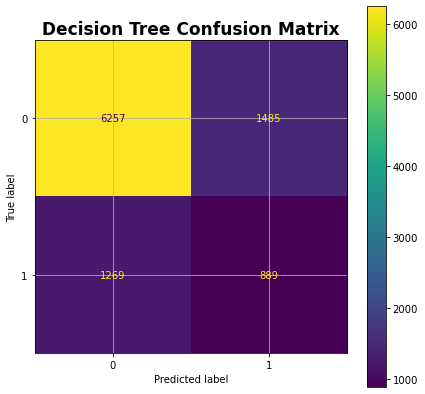

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, mean_squared_error, confusion_matrix
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(decision_tree_model, X_test, y_test, ax=ax)
plt.grid(b = None)
plt.title('Decision Tree Confusion Matrix', fontweight="bold", fontsize=17);

So as we can predicted, the decision tree totally overfit the data! We won't mind too much now about the complete disregard for the class balance, but lets try the random forest model we built.

In [7]:
#Normal test train split holding out about a third of the data 
X_train, X_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.33, random_state=42)

In [8]:
#We initial the algorithm by trying just 20 bags to start and the recommended size of the bag 
#(63% of train data) 
our_random_forest = RandomForestClassifier(20, 0.63)

In [9]:
our_random_forest.fit(X_train, y_train)

In [10]:
#See how it scores on the training data:
our_random_forest.score(X_train, y_train)

In [11]:
our_random_forest.accuracy

0.9696019900497512

In [12]:
our_random_forest.confusion_matrix

,Predicted: 0,Predicted: 1
Actual,,
0,15508,497
1,114,3981


In [13]:
print(our_random_forest.class_accuracy_analysis)

----------------------------------------------------
Class 0 Accuracy: 0.9689472039987503
----------------------------------------------------
Class 1 Accuracy: 0.9721611721611721
----------------------------------------------------


Check out how our accuracy is still really high and it seems to be pretty good at balancing the classes! None of this matters until we see how it does on the test data. Now's the moment of truth! 

In [14]:
test_scores = our_random_forest.score(X_test, y_test)

In [15]:
test_scores.accuracy

0.8063636363636364

In [16]:
test_scores.confusion_matrix

,Predicted: 0,Predicted: 1
Actual,,
0,7150,1325
1,592,833


In [17]:
print(our_random_forest.class_accuracy_analysis)

----------------------------------------------------
Class 0 Accuracy: 0.8436578171091446
----------------------------------------------------
Class 1 Accuracy: 0.584561403508772
----------------------------------------------------


So a quick analysis. The random forest model is still way overfitting on training data, but not nearly as badly as a single decision tree. To continue to improve the accuracy on unseen test data, we simply need more trees than 20. Of course, the number of trees is a hyper parameter that we have to tune to be maximally effective. But for the sake of time, lets try 500. This is where the implementation of *sk-learn*'s random forest becomes a lot better than ours, since this could take a while.  

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.33, random_state=42)
random_forest_model = RandomForestClassifier(500, 0.63)
random_forest_model.fit(X_train, y_train)

In [32]:
train_scores = random_forest_model.score(X_train, y_train)

In [33]:
train_scores.accuracy

0.9892039800995025

In [34]:
print(train_scores.class_accuracy_analysis)

----------------------------------------------------
Class 0 Accuracy: 0.9865453856357779
----------------------------------------------------
Class 1 Accuracy: 0.9990630124150855
----------------------------------------------------


Funny, the training scores increased a lot! Let's check the test data.

In [35]:
test_scores = random_forest_model.score(X_test, y_test)

In [36]:
test_scores.accuracy

0.8174747474747475

In [37]:
print(test_scores.class_accuracy_analysis)

----------------------------------------------------
Class 0 Accuracy: 0.843262001156738
----------------------------------------------------
Class 1 Accuracy: 0.6398406374501993
----------------------------------------------------


In [38]:
test_scores.confusion_matrix

,Predicted: 0,Predicted: 1
Actual,,
0,7290,1355
1,452,803


What's important to see here, is that by adding more trees, the accuracy increased slightly, but more importantly, the accuracy of the minority classification increased a good amount.  